In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**removing the previously used folder**

In [2]:
!rm -rf 'Images'
!rm -rf 'captions.txt'
!rm -rf '*.wav'

**unzipping the flicker 8k data**

In [3]:
from zipfile import ZipFile
dir = "/content/drive/MyDrive/flicker8k.zip"
with ZipFile(dir) as z:
  z.extractall()

In [4]:
!pip install gTTs

**importing the necessery libery**

In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
from gtts import gTTS #Import Google Text to Speech
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Audio #Import Audio method from IPython's Display Class
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re
from keras.preprocessing.image import load_img 
import warnings 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img 
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import datetime
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications import MobileNetV2
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk import tokenize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.stem.snowball import SnowballStemmer
from keras import backend as K

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**setting the random seed 30 for every iteration**

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

**Step 1:- Data loading and Preprocessing**

Define our image and caption path and check how many total images are present in the dataset.

In [7]:
PATH = "/content/Images"

In [8]:
image_path = PATH
dir_Flickr_text = "/content/captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


We create a dataframe to store the image id and captions for ease of use

In [9]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()
count=0
datatxt = []
sentance=[]
for line in text.split('\n'):
   if count >0 and count<40456:
      sentance = line.split(",",1)
      sentance.append(str(count-1))
      datatxt.append(sentance)    
   count+=1
   
data = pd.DataFrame(datatxt,columns=["filename","caption","index"])
data = data.reindex(columns =['index','filename','caption'])
uni_filenames = np.unique(data.filename.values)
data.tail(10)

,index,filename,caption
40445,40445,997338199_7343367d7f.jpg,A person stands near golden walls .
40446,40446,997338199_7343367d7f.jpg,a woman behind a scrolled wall is writing
40447,40447,997338199_7343367d7f.jpg,A woman standing near a decorated wall writes .
40448,40448,997338199_7343367d7f.jpg,The walls are covered in gold and patterns .
40449,40449,997338199_7343367d7f.jpg,"""Woman writing on a pad in room with gold , de..."
40450,40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .
40454,40454,997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


let’s visualize a few images and their 5 captions:

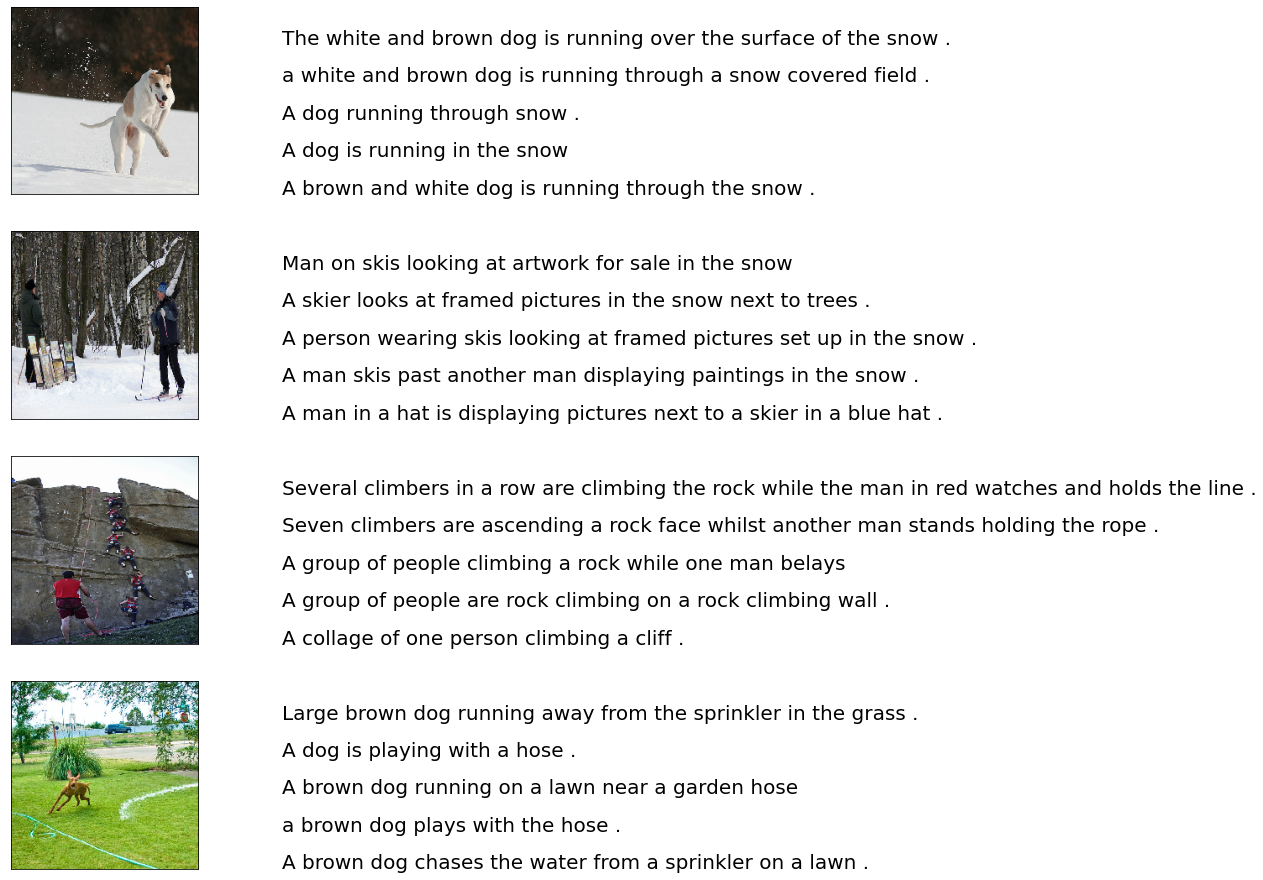

In [10]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

let’s see what our current vocabulary size is

In [11]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 9862


Next perform some text cleaning such as removing punctuation, single characters, numeric values ,lammatizion

In [12]:
def scrub_words(text):
   scrub_words = ""
   for word in text.split():
      word=re.sub("(<.*?>)","",word)
      word=re.sub("(\\W|\\d)"," ",word)
      word=text.strip()
      scrub_words += " " + word
   return scrub_words
def nltk2wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None
def stemmer(text):
   tok = tokenize.word_tokenize(text)
   stemmer = SnowballStemmer("english", ignore_stopwords=True)
   stems = [stemmer.stem(i) for i in tok ]
   alphas = [i for i in stems if i.isalpha()]
   return " ".join(alphas)
   return text
def lemmatize_sentence(sentence):
  lemmatizer = WordNetLemmatizer()
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
  wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
  res_words = []
  for word, tag in wn_tagged:
    if tag is None:                        
      res_words.append(word)
    else:
      res_words.append(lemmatizer.lemmatize(word, tag))
  return " ".join(res_words)
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = text_original.lower()
   #text = scrub_words(text)
   text = remove_punctuation(text)
   text = remove_single_character(text)
   text = remove_numeric(text)
   text =lemmatize_sentence(text)
   #text = stemmer(text)
   
   return(text)

In [13]:
for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

let’s see the size of our vocabulary after cleaning

In [14]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 6524


Next, we save all the captions and image paths in two lists so that we can load the images at once using the path set. We also add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption

In [15]:
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)
all_captions[:10]

['<start> child in pink dress be climb up set of stair in an entry way <end>',
 '<start> girl go into wooden building <end>',
 '<start> little girl climb into wooden playhouse <end>',
 '<start> little girl climb the stair to her playhouse <end>',
 '<start> little girl in pink dress go into wooden cabin <end>',
 '<start> black dog and spot dog be fight <end>',
 '<start> black dog and dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spot be star at each other in the street <end>',
 '<start> two dog of different breed look at each other on the road <end>',
 '<start> two dog on pavement move toward each other <end>']

In [16]:
PATH=PATH+'/'
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg']

Now you can see we have 40455 image paths and captions.

In [17]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [18]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

In [19]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = keras.applications.mobilenet_v2.preprocess_input(img)
   return img, image_path

We will take only 40000 of each so that we can select batch size properly i.e. 625 batches if batch size= 64. To do this we define a function to limit the dataset to 40000 images and captions.

In [20]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

**Step 2:- Model Definition**

Let’s define the image feature extraction model using mobilenet(image net). We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the model. We must all preprocess all the images to the same size, i.e, 224×224 before feeding them into the model.

In [21]:
image_model =MobileNetV2(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________

let’s Map each image name to the function to load the image

In [22]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

We extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [23]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))
 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [01:07<00:00,  1.89it/s]

CPU times: user 1min, sys: 6.89 s, total: 1min 7s
Wall time: 1min 7s


we tokenize the captions and build a vocabulary of all the unique words in the data. We will also limit the vocabulary size to the top 5000 words to save memory. We will replace words not in vocabulary with the token < unk >

In [24]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

Let’s visualize the padded training and captions and the tokenized vectors

In [25]:
train_captions[:3]

['<start> several child leap into pile of leaf on the ground <end>',
 '<start> man hike in the wilderness give the camera thumb up <end>',
 '<start> white dog be run through the water onto the shore <end>']

In [26]:
train_seqs[:3]

[[2, 185, 28, 160, 63, 470, 12, 334, 7, 5, 161, 3],
 [2, 11, 426, 4, 5, 1939, 486, 5, 92, 906, 54, 3],
 [2, 17, 8, 6, 19, 35, 5, 26, 237, 5, 280, 3]]

we can calculate the max and min length of all captions

In [27]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 32 : 2


Next, Create training and validation sets using an 80-20 split and Define the parameters for training

In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

let’s create a tf.data dataset to use for training our model.

In [29]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

let’s define the encoder-decoder architecture with attention.

In [30]:
class MobileNetV2_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(MobileNetV2_Encoder, self).__init__()
       # shape after fc == (70, 49, 640)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [31]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru =tf.compat.v1.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)
   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
   self.fc2 = tf.keras.layers.Dense(vocab_size)
   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)
 
 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
   hidden_with_time_axis = tf.expand_dims(hidden, 1)
   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''
   attention_weights = tf.nn.softmax(score, axis=1)
   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * MobileNet features) '''
   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)
   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)
   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)
   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU
   output, state = self.gru(x)
   # shape == (64, 32, 512)
   x = self.fc1(output)
   # x shape == (64 * 32, 512)
   x = tf.reshape(x, (-1, x.shape[2]))
   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)
   # output shape == (64 * 512)
   x = self.fc2(x)
   # shape : (64 * 6524(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))

we define the loss function and optimizers

In [32]:
def loss_function(real, pred,loss_object):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask
 return tf.reduce_mean(loss_)
def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')
    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

**Step 3:- Model Training**

let’s define the training step. We make use of a technique called Teacher Forcing, which is the technique where the target word is passed as the next input to the decoder. This technique helps to learn the correct sequence or correct statistical properties for the sequence, quickly.

In [33]:
@tf.function
def train_step(img_tensor, target,encoder,decoder,optimizer):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image
 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
         loss += loss_function(target[:, i], predictions,loss_object)
         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

defining the main starter class which will call the model traing with call back

In [34]:
def main_starter(dataset,EPOCHS,start_epoch,encoder,decoder,optimizer,checkpoint, checkpoint_prefix):
  loss_plot = []
  for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss
        if batch % 100 == 0:#later point need to change to 100
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                          total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    checkpoint_prefix_new=checkpoint_prefix+'_'+'Epoch_{}_loss_{:.4f}'.format(epoch + 1,
                                          total_loss/num_steps)+'_.h5'
    checkpoint.save(file_prefix = checkpoint_prefix_new)
  return loss_plot

we train the model

In [35]:
encoder = MobileNetV2_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
EPOCHS=20
start_epoch=0
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
          os.mkdir(model_name)
checkpoint_dir = './'+model_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
loss_plot=main_starter(dataset,EPOCHS,start_epoch,encoder,decoder,optimizer,checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 2.7198
Epoch 1 Batch 100 Loss 1.5161
Epoch 1 Batch 200 Loss 1.3430
Epoch 1 Batch 300 Loss 1.3642
Epoch 1 Batch 400 Loss 1.1319
Epoch 1 Loss 1.400278
Time taken for 1 epoch 200.40206599235535 sec

Epoch 2 Batch 0 Loss 1.1948
Epoch 2 Batch 100 Loss 1.1671
Epoch 2 Batch 200 Loss 1.1098
Epoch 2 Batch 300 Loss 1.0625
Epoch 2 Batch 400 Loss 1.2450
Epoch 2 Loss 1.113967
Time taken for 1 epoch 142.00519514083862 sec

Epoch 3 Batch 0 Loss 1.0117
Epoch 3 Batch 100 Loss 1.0124
Epoch 3 Batch 200 Loss 0.9598
Epoch 3 Batch 300 Loss 1.0288
Epoch 3 Batch 400 Loss 0.9709
Epoch 3 Loss 1.006250
Time taken for 1 epoch 142.04935431480408 sec

Epoch 4 Batch 0 Loss 0.8446
Epoch 4 Batch 100 Loss 1.0215
Epoch 4 Batch 200 Loss 0.9107
Epoch 4 Batch 300 Loss 0.9695
Epoch 4 Batch 400 Loss 0.9049
Epoch 4 Loss 0.926026
Time taken for 1 epoch 141.62085461616516 sec

Epoch 5 Batch 0 Loss 0.7892
Epoch 5 Batch 100 Loss 0.7231
Epoch 5 Batch 200 Loss 0.8182
Epoch 5 Batch 300 Loss 0.9466
Epoch 5 Batch 

Let’s plot the error graph

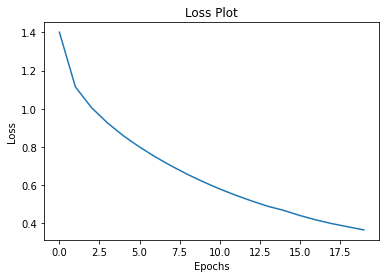

In [36]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

**Step 4:- Greedy Search Beam Search**

creating attention plot

In [37]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       if(len_result>2):
        ax = fig.add_subplot(len_result//2+len_result%2, len_result//2+len_result%2, l+1)
       else:
        ax = fig.add_subplot(1, 2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

creating greedy evaluation algo

In [38]:
def greedy_evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           break

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]
   #remove "<unk>" in result
   for i in result:
     if i=="<unk>":
       result.remove(i)
    #remove <end> from result        
   result_join = ' '.join(result)
   result_final = result_join.rsplit(' ', 1)[0]
   return result_final, attention_plot

defining beam evalution algo with default beam index as 3

In [39]:
def beam_evalution(image,beam_index=3):
  attention_plot = np.zeros(((max_length-1)*beam_index, attention_features_shape))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  result = []
  count=0
  start=[tokenizer.word_index['<start>']]
  start_word = [[start, 0.0]]
  while len(start_word[0][0]) < max_length:
    temp=[]
    for s in start_word:
        dec_input = tf.expand_dims([s[0][-1]], 0)
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[count] = tf.reshape(attention_weights, (-1, )).numpy()
        count+=1
        tf.reshape(attention_weights,(-1,)).numpy()
        word_preds = tf.argsort(predictions[0]).numpy()[-beam_index:]
        for w in word_preds:
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            predictions += predictions[0][w]
            temp.append([next_cap, prob])
    start_word = temp
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
    start_word = start_word[-beam_index:]
  start_word = start_word[-1][0]
  intermediate_caption = [tokenizer.index_word[i] for i in start_word]
  final_caption = []  
  for i in intermediate_caption:
    if i != '<end>':
      final_caption.append(i)
    else:
      break
  attention_plot = attention_plot[:len(final_caption), :]
  final_caption = ' '.join(final_caption[1:])
  return final_caption, attention_plot


test using greedy prediction

In [40]:
def test_Train_greedy_pediction(rid):
  image = img_name_val[rid]
  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result_final, attention_plot = greedy_evaluate(image)
  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]
  real_caption=text_clean(real_caption)
  score = sentence_bleu([real_caption.split()], result_final.split())
  print(f"BELU score: {score*100}")
  print('Real Caption:', real_caption)
  print('Prediction Caption:', result_final)
  print(f"time took to Predict: {round(time.time()-start)} sec")
  tts = gTTS(result_final) #Provide the string to convert to speech
  plot_attention(image,result_final.split(),attention_plot)
  tts.save(str(rid)+'_greedy_Audio_file.wav') #save the string converted to speech as a .wav file
  plt.imshow(Image.open(image))

test using beam prediction

In [53]:
def test_Train_beam_pediction(rid,beam_index):
  image = img_name_val[rid]
  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result_final, attention_plot = beam_evalution(image,beam_index)
  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]
  real_caption=text_clean(real_caption)
  score = sentence_bleu([real_caption.split()], result_final.split())
  print(f"BELU score: {score*100}")
  print('Real Caption:', real_caption)
  print('Prediction Caption:', result_final)
  print(f"time took to Predict: {round(time.time()-start)} sec")
  tts = gTTS(result_final) #Provide the string to convert to speech
  plot_attention(image,result_final.split(),attention_plot)
  tts.save(str(rid)+'_beam_Audio_file.wav') #save the string converted to speech as a .wav file
  plt.imshow(Image.open(image))

**Step 5 : Testing**

test using greedy algo on random test data

BELU score: 61.47881529512643
Real Caption: white dog in creek
Prediction Caption: tan dog be jump into the water
time took to Predict: 0 sec


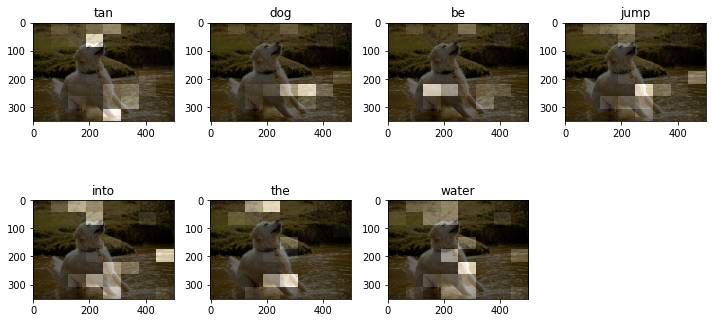

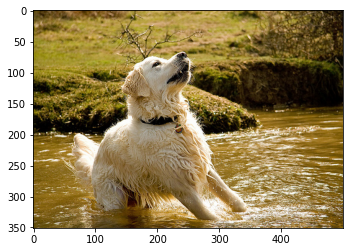

In [49]:
rid = np.random.randint(0, len(img_name_val))
test_Train_greedy_pediction(rid)
sound_file = str(rid)+'_greedy_Audio_file.wav'
Audio(sound_file, autoplay=True)

test using beam algo on random test data (beam index=4)

BELU score: 54.44460596606694
Real Caption: man stand in front of very tall building
Prediction Caption: man stand in front of skyscraper
time took to Predict: 3 sec


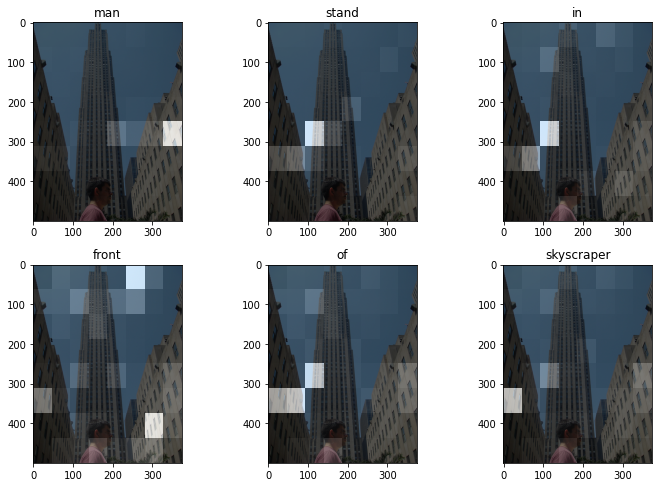

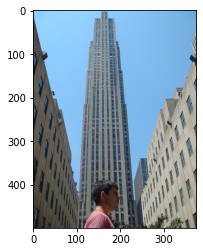

In [54]:
rid = np.random.randint(0, len(img_name_val))
test_Train_beam_pediction(rid,4)
sound_file = str(rid)+'_beam_Audio_file.wav'
Audio(sound_file, autoplay=True)